# Environment

In [ ]:
# keep the connection of Colab
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

In [ ]:
# Download the dataset

# Google Drive
!gdown --id '1rPBGXzJBDStHF0Jlxq4kP5KJDqVe3zNd' --output dataset.zip

# Unzip the dataset.
!unzip -q dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rPBGXzJBDStHF0Jlxq4kP5KJDqVe3zNd
To: /content/dataset.zip
100% 193M/193M [00:04<00:00, 41.7MB/s]


In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [ ]:
DF = pd.read_csv(f'dataset.csv')
print(DF.shape)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
label_class = ['benign','fraud']

(588957, 383)


In [ ]:
def getXy(ratio):
  df = DF.sample(frac=ratio, random_state=RANDOM_SEED)
  X = df.iloc[:,2:].values
  y = df.iloc[:,1].values
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
  print(f'X_train size: {X_train.shape}')
  return X_train, X_test, y_train, y_test

def generateResult(model, X_test, y_test, TF = 0):
  if TF == 1:
    predict = model.predict(X_test)
    predict = np.argmax(predict, axis=1)
    y_test = np.argmax(y_test, axis=1)
  else:
    predict = model.predict(X_test)
  ACCURACY = accuracy_score(predict, y_test)
  PRECISION = precision_score(predict, y_test, average='macro')
  RECALL = recall_score(predict, y_test, average='macro')
  F1 = f1_score(predict, y_test, average='macro')
  print('Accuracy Score: ', ACCURACY)
  print('Recall Score: ', PRECISION)
  print('Precision Score: ', RECALL)
  print('F1-Score: ', F1)
  CM = confusion_matrix(y_test, predict)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = label_class)
  cm_display.plot()
  plt.show()
  return ACCURACY, PRECISION, RECALL, F1

def comparisonPlot(L, title):
  chart = pd.DataFrame([L], columns=['Random Forest', 'GBM', 'LSTM'])
  chart = chart.plot(kind='bar',title=title, figsize=(8,6), ylim=[0.0, 1.1])
  for col in chart.patches:
    chart.annotate(str(round(col.get_height(),3)), (col.get_x() * 1.005, col.get_height() * 1.005))
  plt.show()

def summaryPlot(L, title, ratios):
  chart = pd.DataFrame(L, columns=['Random Forest', 'GBM', 'LSTM'], index=ratios)
  print(chart)
  chart = chart.plot(kind='line', marker='o', title=title, figsize=(8,6), ylim=[0.0, 1.1])
  for a, b in zip(np.array(ratios).repeat(len(L[0])), np.array(L).flatten()):
    plt.text(a, b+0.05, round(b, 3), ha='center', va='bottom', fontsize=7)
  plt.show()

# Models

In [ ]:
def RF_method(X_train, y_train, X_test, y_test, n=100):
  model = RandomForestClassifier(n_estimators=n, random_state=RANDOM_SEED)
  model.fit(X_train, y_train)
  return generateResult(model, X_test, y_test)

def GBM_method(X_train, y_train, X_test, y_test, n=100, lr=0.1):
  model = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, random_state=RANDOM_SEED)
  model.fit(X_train, y_train)
  return generateResult(model, X_test, y_test)

def LSTM_method(X_train, y_train, X_test, y_test, epochs=5, lr=0.001):
  model = Sequential()
  model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
  model.add(LSTM(32))
  model.add(Dense(2, activation='sigmoid'))
  optimizer = Adam(learning_rate=lr)
  class_weights = {0: 1, 1: 10}
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_train = tf.keras.utils.to_categorical(y_train.reshape(-1, 1), num_classes=2)
  y_test = tf.keras.utils.to_categorical(y_test.reshape(-1, 1), num_classes=2)
  model.fit(X_train, y_train, epochs=epochs, batch_size=256, validation_split=0.2, class_weight=class_weights)
  return generateResult(model, X_test, y_test, 1)

# Experiment

------------------------------------------------------------------------------
Current Ratio : 0.25
------------------------------------------------------------------------------
X_train size: (117791, 381)
Accuracy Score:  0.9773499049171421
Recall Score:  0.6813013372967376
Precision Score:  0.9485653674406487
F1-Score:  0.7547889601664904


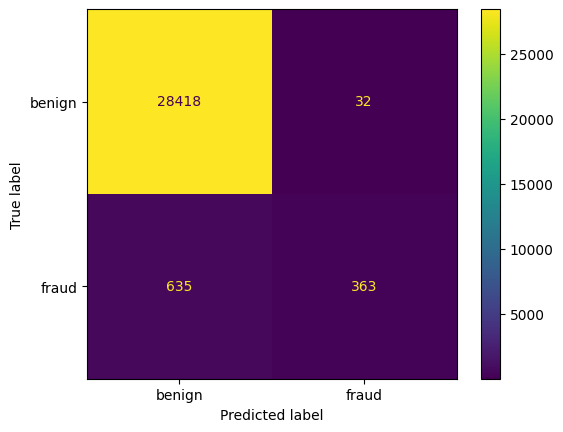

Accuracy Score:  0.9741917957076881
Recall Score:  0.6443766971552948
Precision Score:  0.9118141674532652
F1-Score:  0.7098156448281907


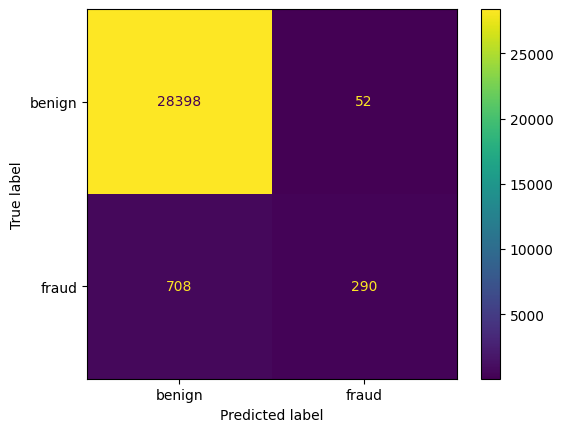

Epoch 1/10
369/369 [==============================] - 26s 39ms/step - loss: 0.7805 - accuracy: 0.9640 - val_loss: 0.3598 - val_accuracy: 0.9608
Epoch 2/10
369/369 [==============================] - 12s 34ms/step - loss: 0.7655 - accuracy: 0.9605 - val_loss: 0.3347 - val_accuracy: 0.9606
Epoch 3/10
369/369 [==============================] - 13s 35ms/step - loss: 0.7168 - accuracy: 0.9441 - val_loss: 0.4034 - val_accuracy: 0.8335
Epoch 4/10
369/369 [==============================] - 13s 34ms/step - loss: 0.6658 - accuracy: 0.9007 - val_loss: 0.3752 - val_accuracy: 0.8440
Epoch 5/10
369/369 [==============================] - 13s 35ms/step - loss: 0.6526 - accuracy: 0.8884 - val_loss: 0.2658 - val_accuracy: 0.9019
Epoch 6/10
369/369 [==============================] - 13s 34ms/step - loss: 0.6427 - accuracy: 0.8895 - val_loss: 0.3524 - val_accuracy: 0.8527
Epoch 7/10
369/369 [==============================] - 13s 34ms/step - loss: 0.6354 - accuracy: 0.8946 - val_loss: 0.2995 - val_accuracy:

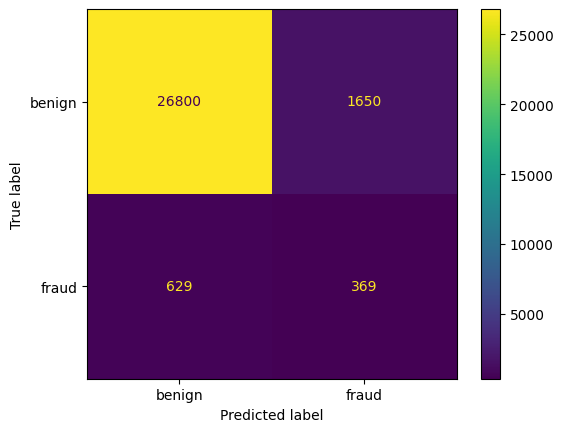

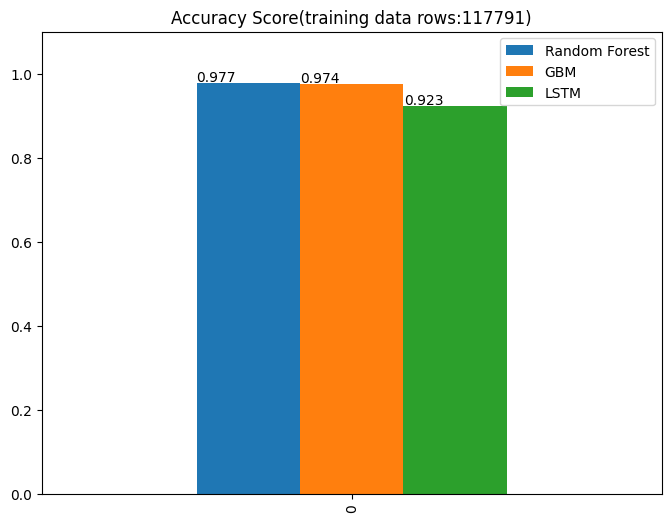

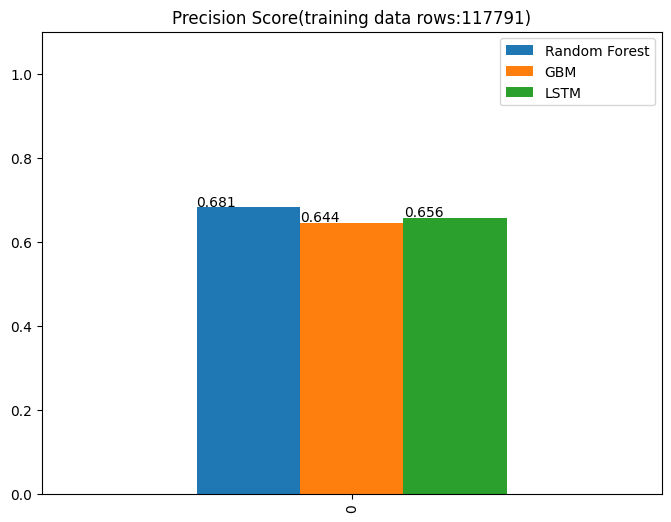

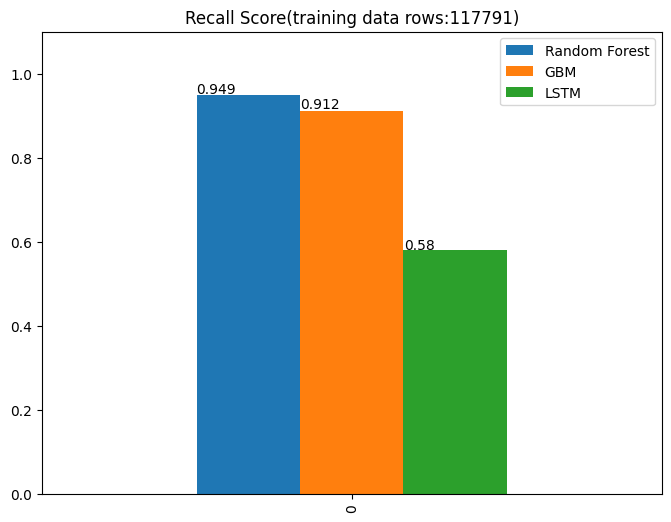

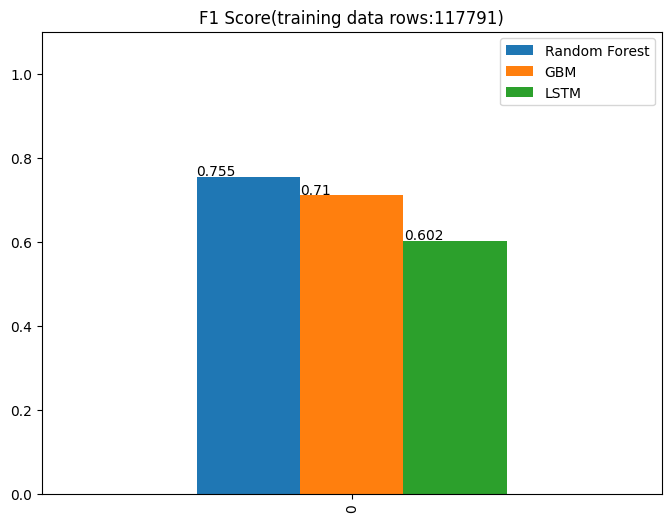

------------------------------------------------------------------------------
Current Ratio : 0.5
------------------------------------------------------------------------------
X_train size: (235582, 381)
Accuracy Score:  0.9778083401249661
Recall Score:  0.70736137709677
Precision Score:  0.9425245336404886
F1-Score:  0.7795497854499369


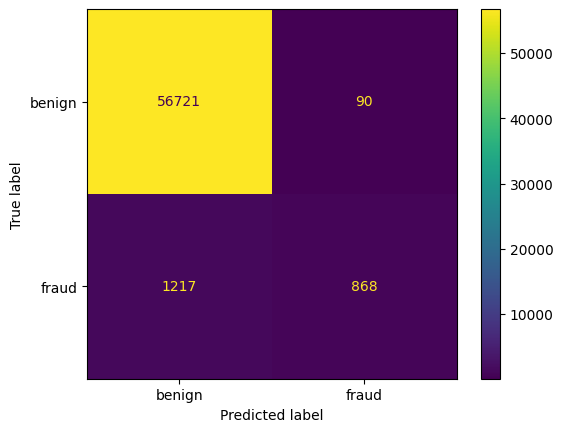

Accuracy Score:  0.9731221135560989
Recall Score:  0.6457944675573899
Precision Score:  0.9111624197043029
F1-Score:  0.7111428561204347


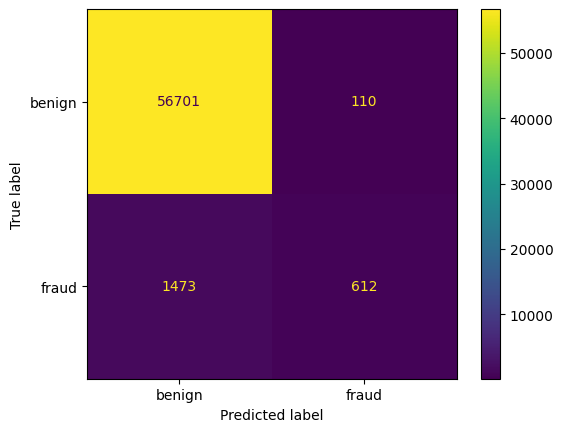

Epoch 1/10
737/737 [==============================] - 30s 36ms/step - loss: 0.7550 - accuracy: 0.9559 - val_loss: 0.3305 - val_accuracy: 0.9285
Epoch 2/10
737/737 [==============================] - 26s 35ms/step - loss: 0.6894 - accuracy: 0.9082 - val_loss: 0.2826 - val_accuracy: 0.9027
Epoch 3/10
737/737 [==============================] - 26s 35ms/step - loss: 0.6759 - accuracy: 0.8945 - val_loss: 0.3283 - val_accuracy: 0.8490
Epoch 4/10
737/737 [==============================] - 26s 35ms/step - loss: 0.6642 - accuracy: 0.8906 - val_loss: 0.2749 - val_accuracy: 0.9094
Epoch 5/10
737/737 [==============================] - 26s 36ms/step - loss: 0.6586 - accuracy: 0.8861 - val_loss: 0.3495 - val_accuracy: 0.8411
Epoch 6/10
737/737 [==============================] - 31s 42ms/step - loss: 0.6503 - accuracy: 0.8875 - val_loss: 0.3326 - val_accuracy: 0.8804
Epoch 7/10
737/737 [==============================] - 29s 39ms/step - loss: 0.6472 - accuracy: 0.8940 - val_loss: 0.2780 - val_accuracy:

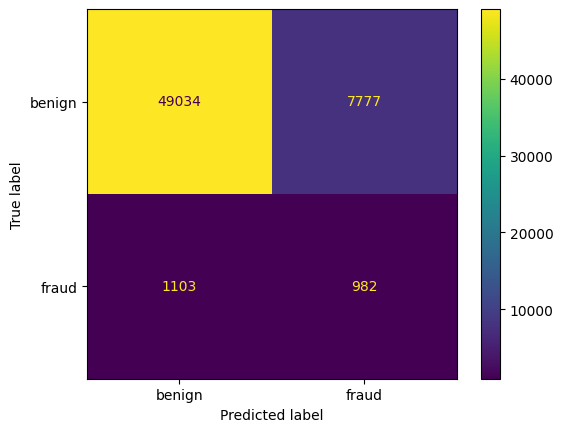

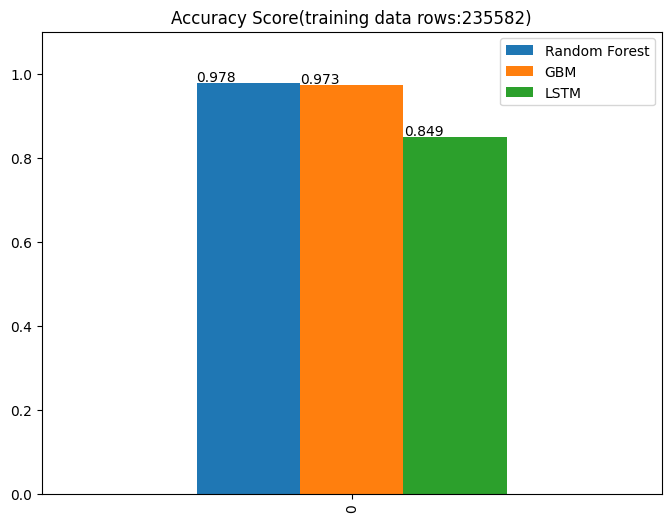

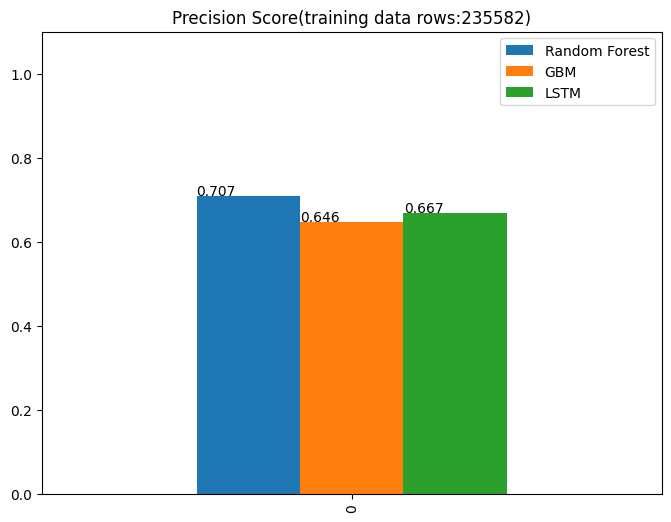

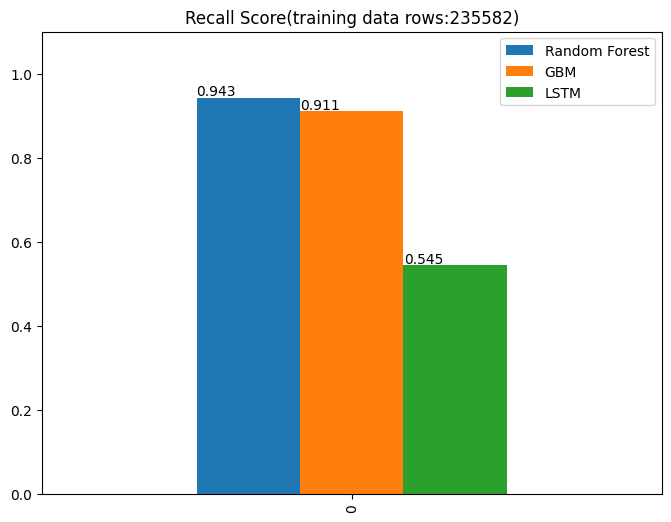

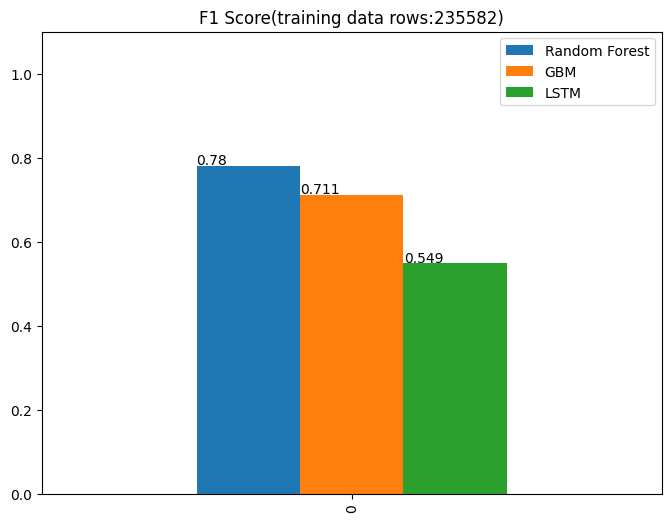

------------------------------------------------------------------------------
Current Ratio : 0.75
------------------------------------------------------------------------------
X_train size: (353374, 381)
Accuracy Score:  0.9786969120709952
Recall Score:  0.7125977636211152
Precision Score:  0.9499411098260581
F1-Score:  0.7859796976671076


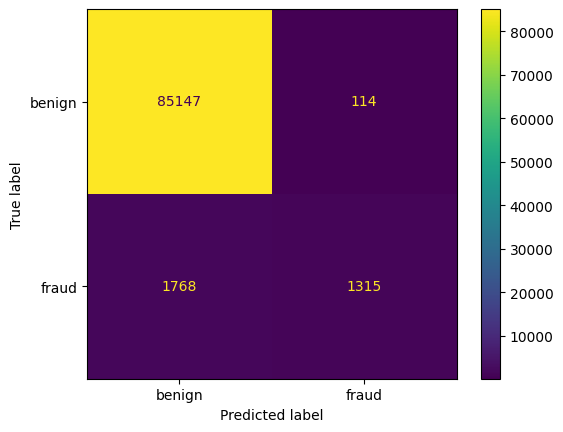

Accuracy Score:  0.973761658969483
Recall Score:  0.6453263542379266
Precision Score:  0.9219300951776161
F1-Score:  0.7119731273514018


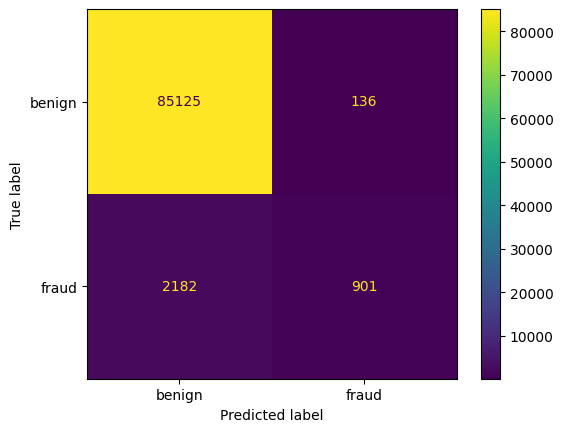

Epoch 1/10
1105/1105 [==============================] - 44s 36ms/step - loss: 0.7501 - accuracy: 0.9590 - val_loss: 0.3138 - val_accuracy: 0.9629
Epoch 2/10
1105/1105 [==============================] - 43s 39ms/step - loss: 0.6978 - accuracy: 0.9272 - val_loss: 0.3514 - val_accuracy: 0.8498
Epoch 3/10
1105/1105 [==============================] - 45s 41ms/step - loss: 0.6745 - accuracy: 0.9080 - val_loss: 0.2792 - val_accuracy: 0.9289
Epoch 4/10
1105/1105 [==============================] - 40s 36ms/step - loss: 0.6730 - accuracy: 0.9091 - val_loss: 0.3170 - val_accuracy: 0.9284
Epoch 5/10
1105/1105 [==============================] - 40s 36ms/step - loss: 0.6677 - accuracy: 0.9011 - val_loss: 0.2799 - val_accuracy: 0.9124
Epoch 6/10
1105/1105 [==============================] - 40s 36ms/step - loss: 0.6690 - accuracy: 0.9030 - val_loss: 0.3342 - val_accuracy: 0.8552
Epoch 7/10
1105/1105 [==============================] - 46s 42ms/step - loss: 0.6575 - accuracy: 0.9006 - val_loss: 0.3477 -

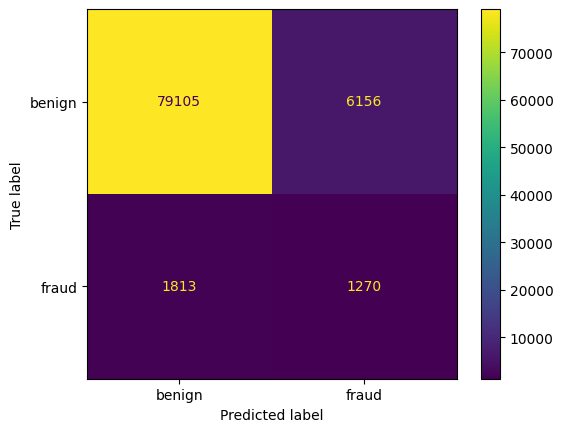

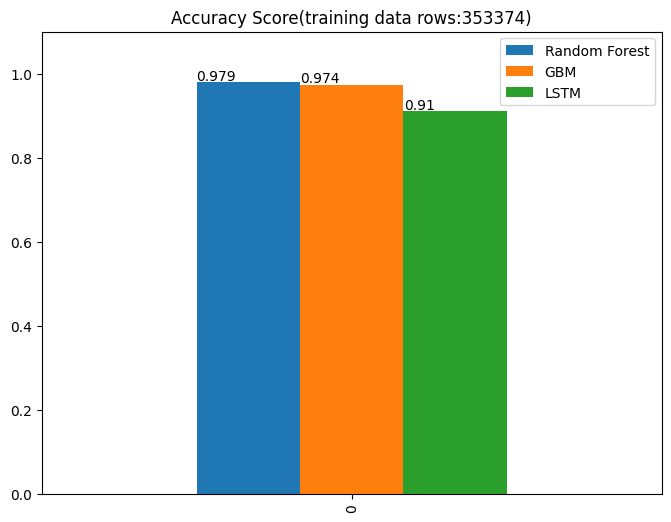

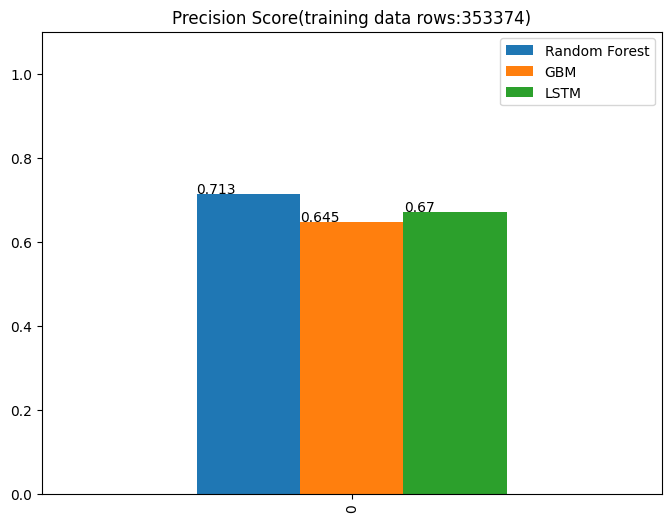

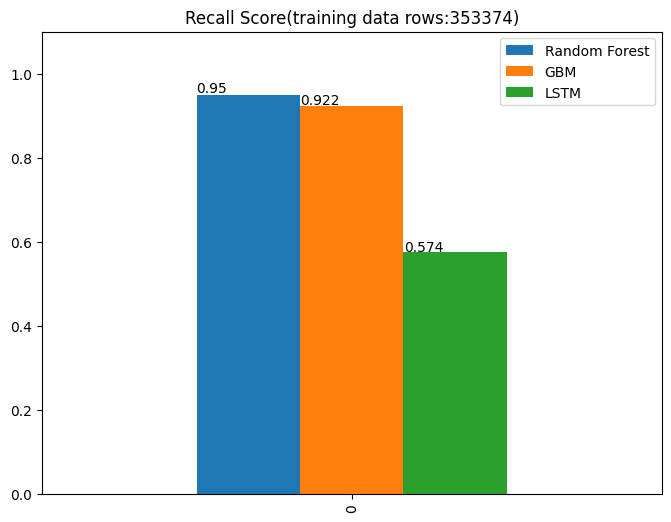

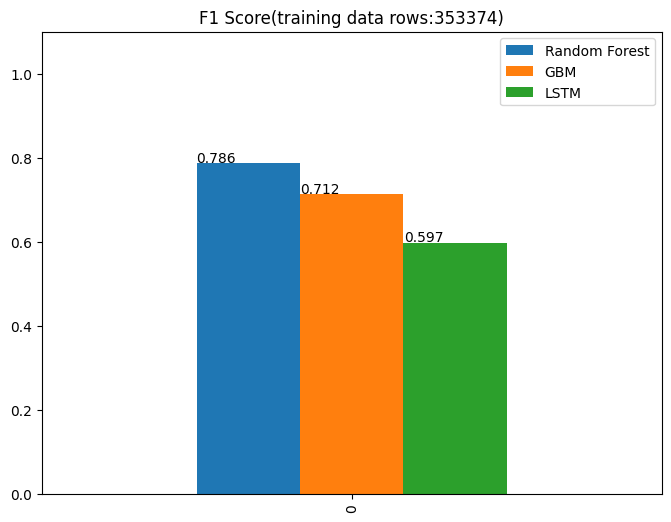

------------------------------------------------------------------------------
Current Ratio : 1
------------------------------------------------------------------------------
X_train size: (471165, 381)
Accuracy Score:  0.9798967671828308
Recall Score:  0.7283013671476152
Precision Score:  0.9562274038481614
F1-Score:  0.801817336831963


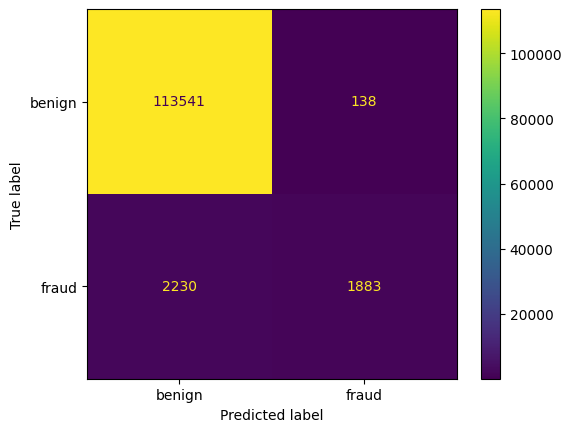

Accuracy Score:  0.9737248709589785
Recall Score:  0.6466015972688886
Precision Score:  0.9182940836916039
F1-Score:  0.7129801564800269


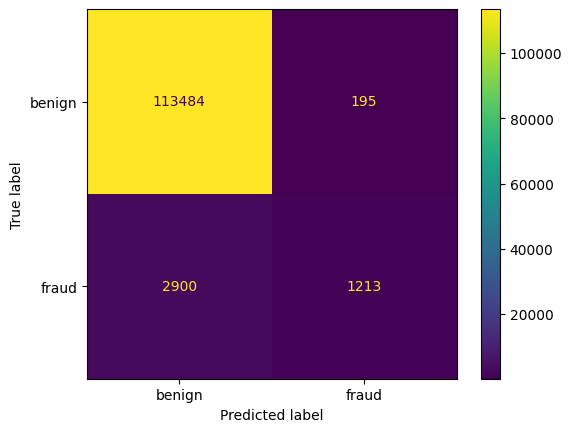

Epoch 1/10
1473/1473 [==============================] - 74s 46ms/step - loss: 0.7185 - accuracy: 0.9398 - val_loss: 0.3303 - val_accuracy: 0.8964
Epoch 2/10
1473/1473 [==============================] - 66s 45ms/step - loss: 0.6748 - accuracy: 0.9039 - val_loss: 0.3072 - val_accuracy: 0.9212
Epoch 3/10
1473/1473 [==============================] - 67s 45ms/step - loss: 0.6578 - accuracy: 0.8955 - val_loss: 0.2975 - val_accuracy: 0.8715
Epoch 4/10
1473/1473 [==============================] - 66s 45ms/step - loss: 0.6453 - accuracy: 0.8861 - val_loss: 0.2883 - val_accuracy: 0.8987
Epoch 5/10
1473/1473 [==============================] - 63s 42ms/step - loss: 0.6432 - accuracy: 0.8906 - val_loss: 0.3002 - val_accuracy: 0.8836
Epoch 6/10
1473/1473 [==============================] - 63s 43ms/step - loss: 0.6360 - accuracy: 0.8971 - val_loss: 0.3056 - val_accuracy: 0.8763
Epoch 7/10
1473/1473 [==============================] - 68s 46ms/step - loss: 0.6277 - accuracy: 0.9034 - val_loss: 0.2997 -

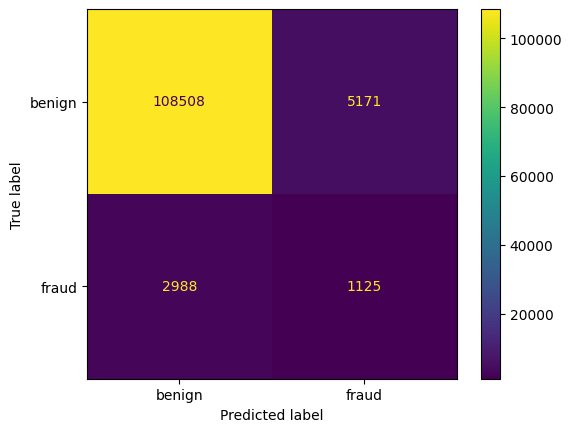

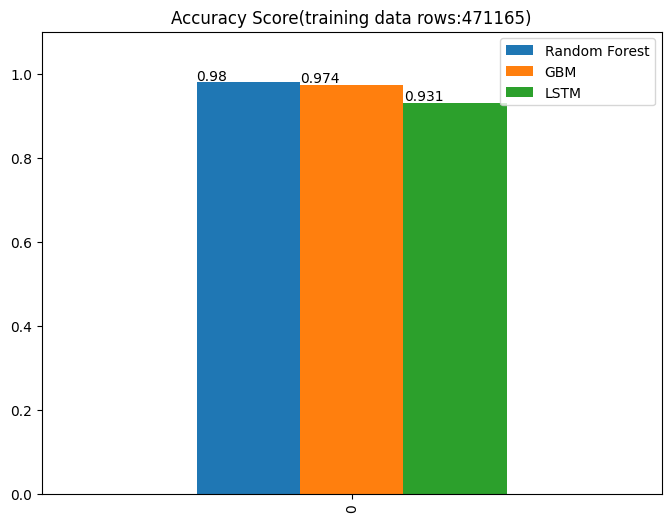

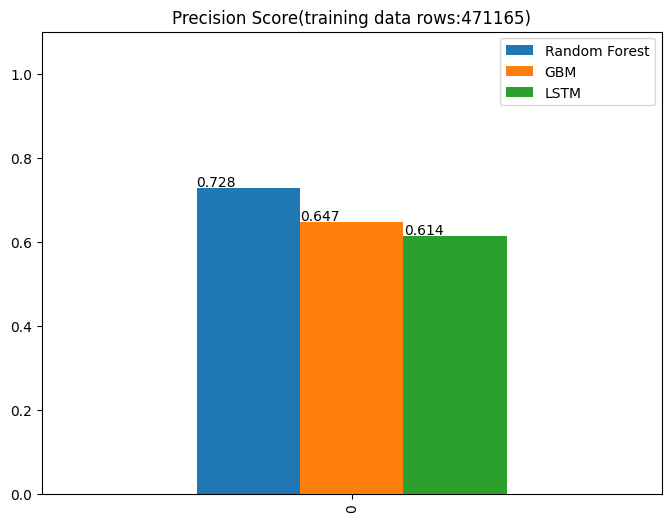

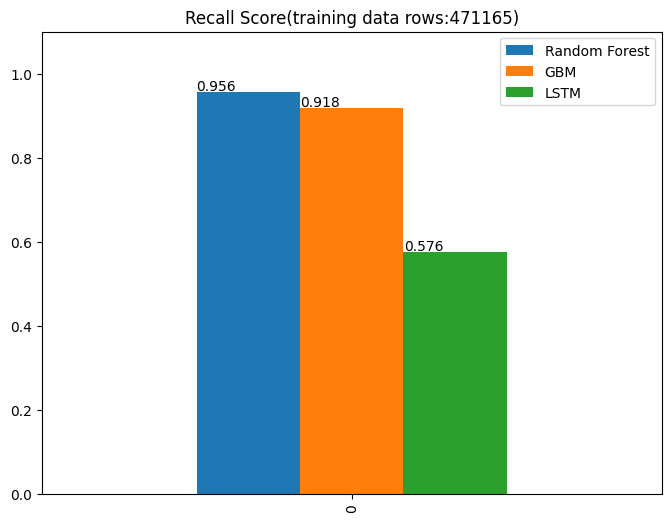

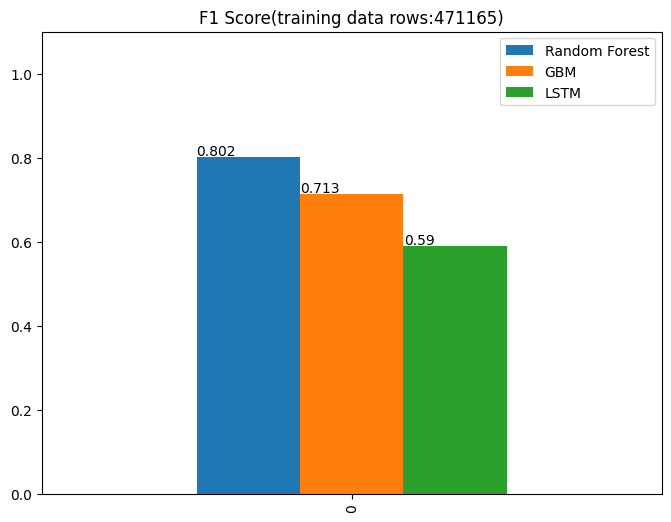

------------------------------------------------------------------------------
Summary:
------------------------------------------------------------------------------
      Random Forest       GBM      LSTM
0.25       0.977350  0.974192  0.922609
0.50       0.977808  0.973122  0.849226
0.75       0.978697  0.973762  0.909796
1.00       0.979897  0.973725  0.930734


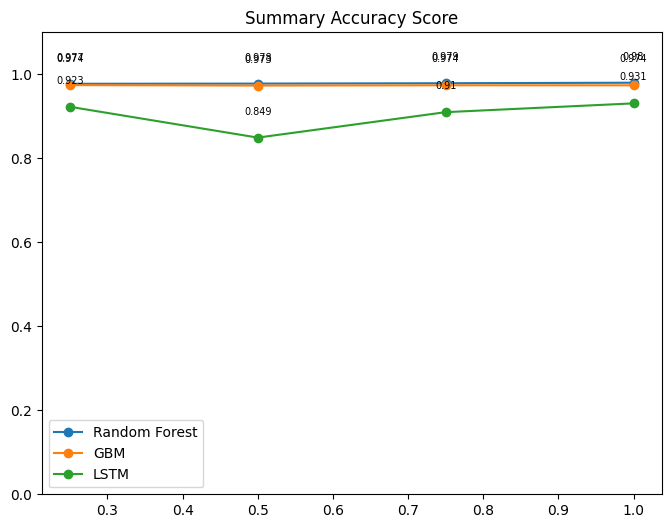

      Random Forest       GBM      LSTM
0.25       0.681301  0.644377  0.655871
0.50       0.707361  0.645794  0.667045
0.75       0.712598  0.645326  0.669867
1.00       0.728301  0.646602  0.614018


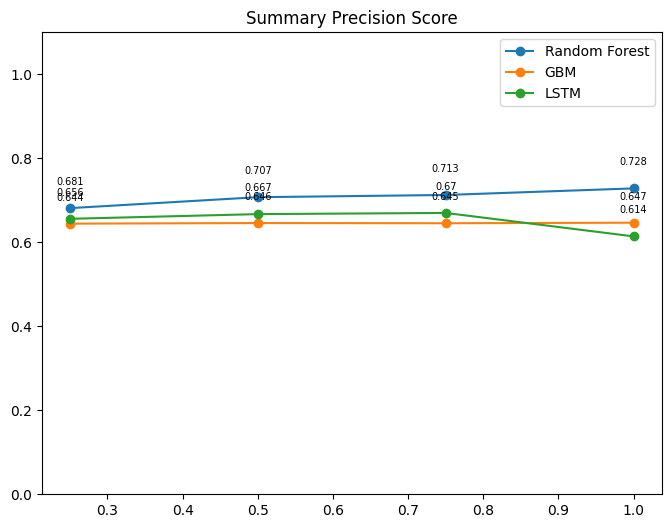

      Random Forest       GBM      LSTM
0.25       0.948565  0.911814  0.579916
0.50       0.942525  0.911162  0.545057
0.75       0.949941  0.921930  0.574308
1.00       0.956227  0.918294  0.575943


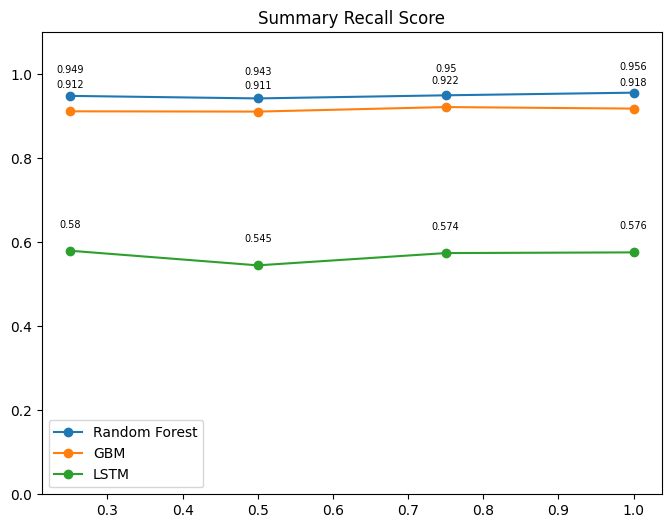

      Random Forest       GBM      LSTM
0.25       0.754789  0.709816  0.601915
0.50       0.779550  0.711143  0.549041
0.75       0.785980  0.711973  0.596872
1.00       0.801817  0.712980  0.589963


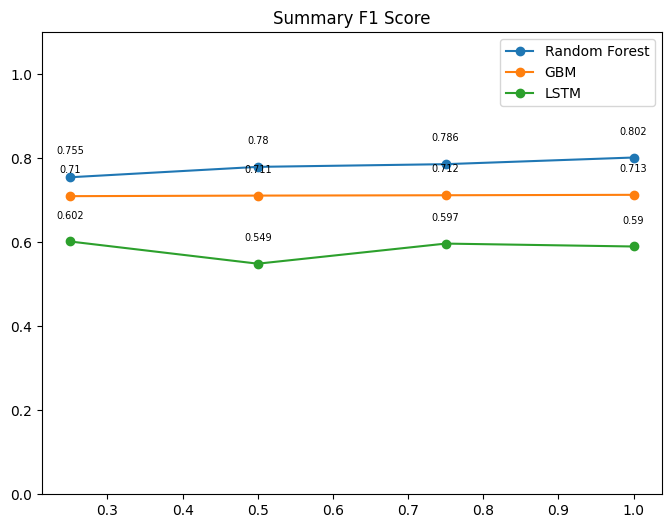

In [ ]:
ratios = [0.25, 0.5, 0.75, 1]
accuracy_records, precision_records, recall_records, f1_records = [], [], [], []
for ratio in ratios:
  print('------------------------------------------------------------------------------')
  print(f'Current Ratio : {ratio}')
  print('------------------------------------------------------------------------------')
  X_train, X_test, y_train, y_test = getXy(ratio)
  RF_accuracy, RF_precision, RF_recall, RF_f1 = RF_method(X_train, y_train, X_test, y_test)
  GBM_accuracy, GBM_precision, GBM_recall, GBM_f1 = GBM_method(X_train, y_train, X_test, y_test)
  LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1 = LSTM_method(X_train, y_train, X_test, y_test, epochs=10)
  # Record the score
  accuracy_record = [RF_accuracy, GBM_accuracy, LSTM_accuracy]
  precision_record = [RF_precision, GBM_precision, LSTM_precision]
  recall_record = [RF_recall, GBM_recall, LSTM_recall]
  f1_record = [RF_f1, GBM_f1, LSTM_f1]
  accuracy_records.append(accuracy_record)
  precision_records.append(precision_record)
  recall_records.append(recall_record)
  f1_records.append(f1_record)
  # Compare models
  comparisonPlot(accuracy_record, title=f'Accuracy Score(training data rows:{len(X_train)})')
  comparisonPlot(precision_record, title=f'Precision Score(training data rows:{len(X_train)})')
  comparisonPlot(recall_record, title=f'Recall Score(training data rows:{len(X_train)})')
  comparisonPlot(f1_record, title=f'F1 Score(training data rows:{len(X_train)})')
print('------------------------------------------------------------------------------')
print('Summary:')
print('------------------------------------------------------------------------------')
summaryPlot(accuracy_records, title=f'Summary Accuracy Score', ratios=ratios)
summaryPlot(precision_records, title=f'Summary Precision Score', ratios=ratios)
summaryPlot(recall_records, title=f'Summary Recall Score', ratios=ratios)
summaryPlot(f1_records, title=f'Summary F1 Score', ratios=ratios)
